# Inference in Larger Graphical Models

## William Koehrsen wjk68

# Introduction

In this notebook, I look at predicting students outcomes using a probabilistic linear model. Student grades are influenced by many factors, and using a linear model allows us to determine the relationships between these variables and the final performance. 

# Problem Statement

This is a supervised regression problem: we have labels, the final performance of students, that we wish to predict from a set of known features. The labels are continuous (from 1-20) which makes this a regression problem (we could also formulate it as a classification with 20 discrete classes but we will treat the grades as continuous. There are many standard machine learning approaches that can be used to create a model mapping the features in the training data to the labels. These models can be easily built in scikit-learn and then tested against a hold-out testing set. We will look at several standard machine learning models in addition to Bayesian Linear Regression for comparison.

## Dataset

The dataset I am using comes for the UCI Machine Learning Repository and has 

### Features 

# Bayesian Linear Regression

The standard linear regression is 

$$ Y = X\beta + \epsilon $$

Where Y is the target, X is the predictor matrix, $\beta$ is the weights vector, and $\epsilon$ is an error term (assumed to be normally distributed. The weights are found using ordinary least squares to minimum the residual sum of squares between the observations (training data) and the fit. 

In a Bayesian framework, Linear Regression takes the form

$$ Y \sim \mathcal{N}(X \beta, \sigma^2) $$

Where Y is a random variable with each data point distributed according to a normal distribution. The mean of the normal distribution comes from the data points multiplied by the weights vector $\beta$ with a variance of $\sigma^2$. 

The Bayesian Linear Regression framework has two main advantages:

* Priors: Any previous knowledge about the problem can be quantified by placing prior probabilities on the model parameters. For example, if we believe one of the explanatory variables has a one-to-one linear relationship with the response, then we can assign the intial starting value of 1 to the corresponding weight. 
* Uncertainty: Bayesian inference using Markov Chain Monte Carlo does not yield a single estimate for each weight, but rather a posterior _distribution_ from which we can draw conclusions about how likely different values of the weights $\beta$ are in our model. With fewer data points, there will be more uncertainty in $\beta$ and the posteriors distributions will thus be very wide. 

## Comparison to other Models

We will start off by solving this regression problem using several standard machine learning models from scikit-learn. This library makes creating, training, and evaluating models very simple. 

In [1]:
import pandas as pd
import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from IPython.core.pylabtools import figsize

In [2]:
# Standard ML Models for comparison
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

# Splitting data into training/testing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Metrics
from sklearn.metrics import mean_squared_error

In [3]:
import pymc3 as pm

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Read in Data and Examine

In [4]:
math = pd.read_csv('data/student-mat.csv', sep=';')
por = pd.read_csv('data/student-por.csv', sep=';')

# Filter out grades that were 0
math = math[math['G3'] != 0]
por = por[por['G3'] != 0 ]
math.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


## Function to Format Data for Machine Learning

In [37]:
def format_data(df):
    # Targets are final grade of student
    labels = df['G3']
    # Drop the school and the grades from features
    df = df.drop(columns=['school', 'G1', 'G2', 'G3'])
    
    # One-Hot Encoding of Categorical Variables
    df = pd.get_dummies(df)
    
    # Split into training/testing sets with 25% split
    X_train, X_test, y_train, y_test = train_test_split(df, labels, 
                                                        test_size = 0.25)
    
    # Scale to between 0 and 1
    scaler = MinMaxScaler(feature_range=(0,1))
    
    # Train scaler on training data and transform all features
    # X_train = scaler.fit_transform(X_train)
    # X_test = scaler.transform(X_test)
    
    # Find correlations
    X_train['y'] = list(y_train)
    most_correlated = X_train.corr().abs()['y'].sort_values(ascending=False)
    
    # Keep correlations greater than 0.1 in absolute value
    most_correlated = most_correlated[most_correlated > 0.15][1:]
    
    X_train = X_train.ix[:, most_correlated.index]
    X_test = X_test.ix[:, most_correlated.index]
    
    return X_train, X_test, y_train, y_test
    

In [119]:
X_train_math, X_test_math, y_train_math, y_test_math = format_data(math)

## Plot Data for Exploration

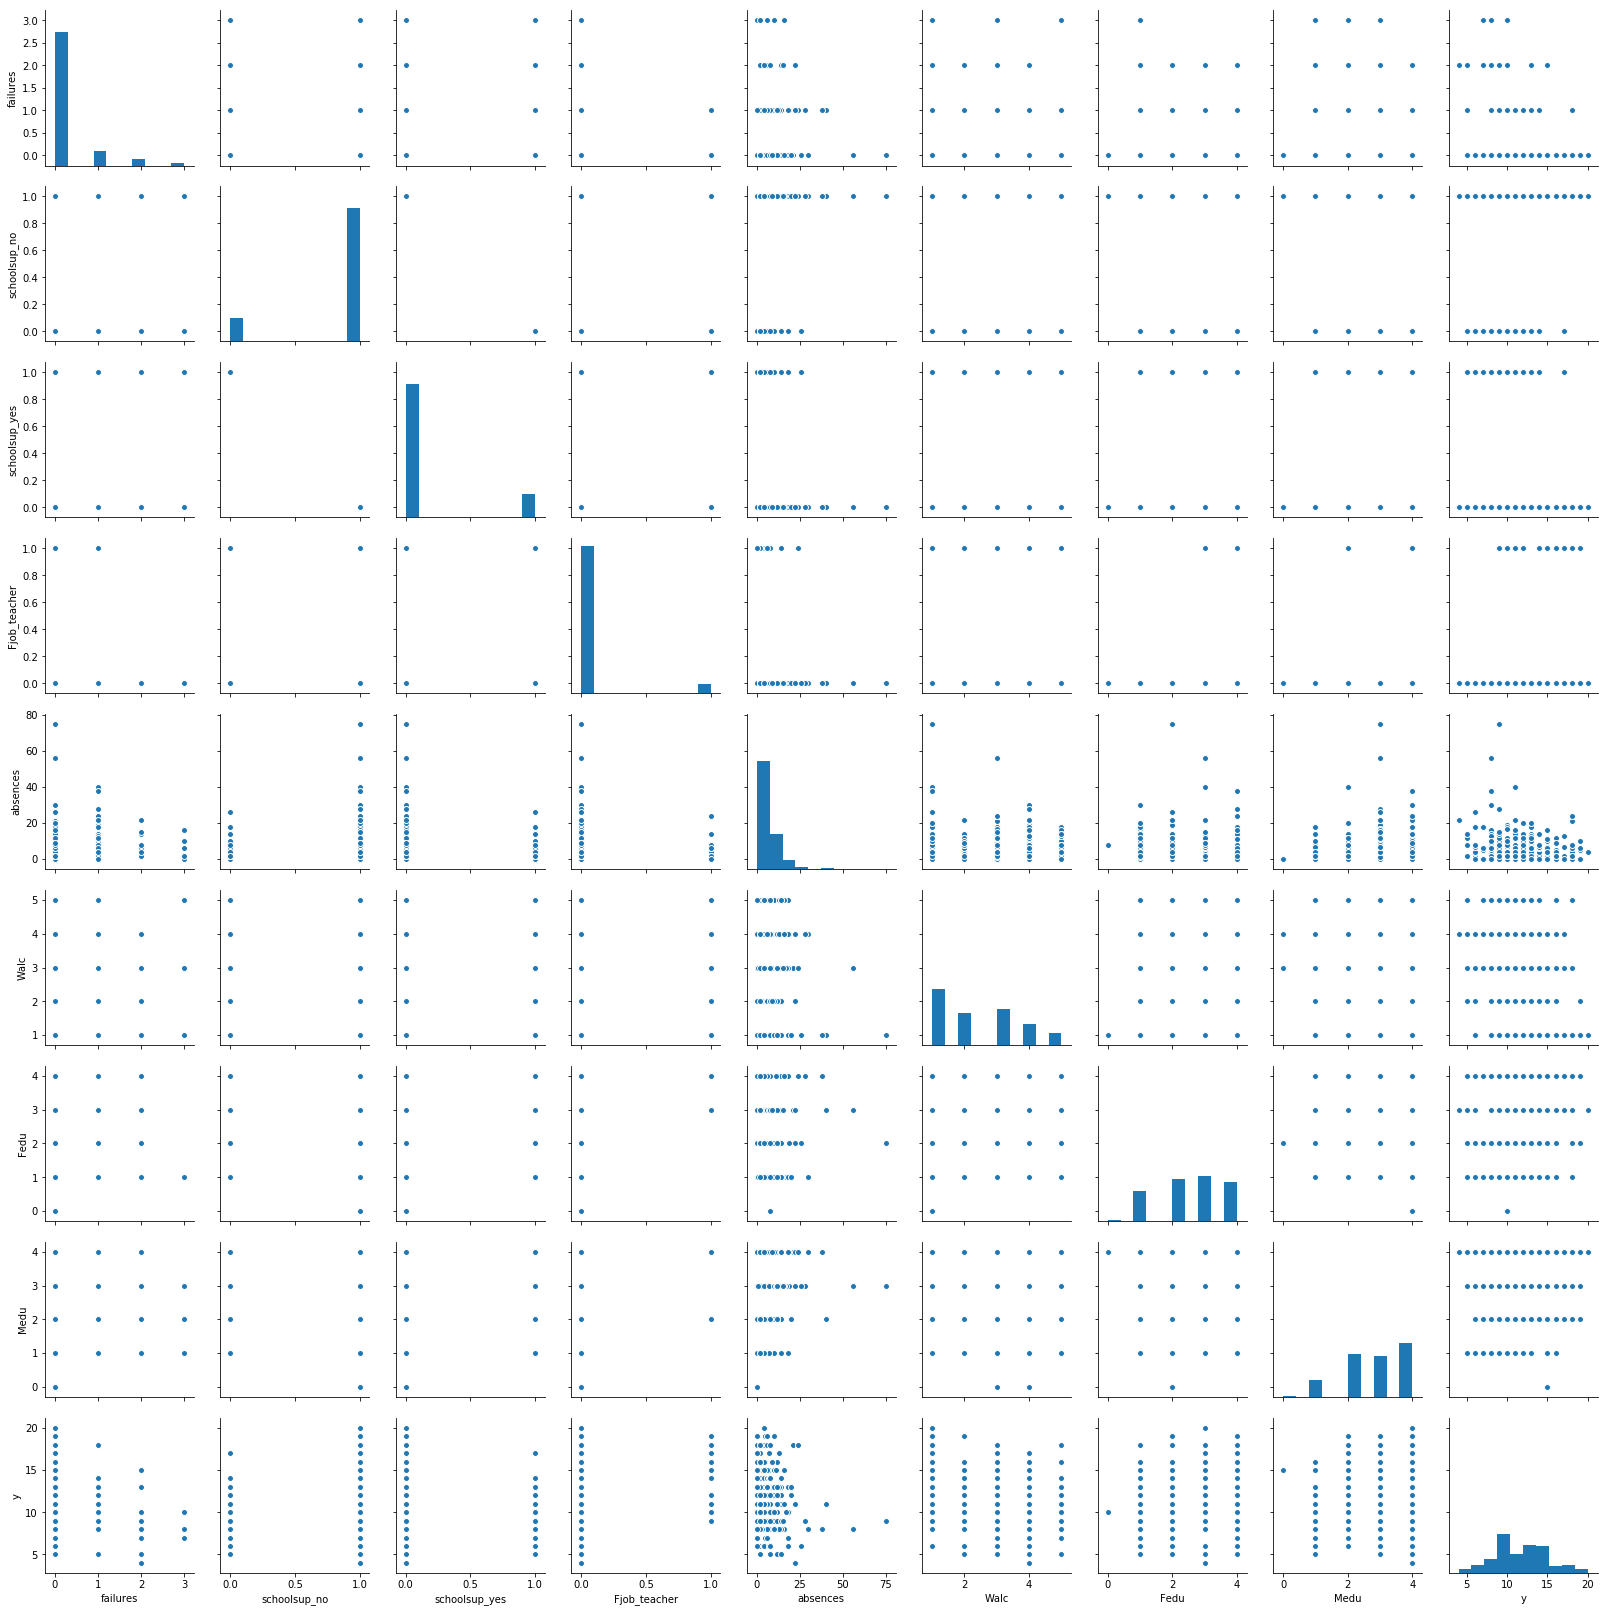

In [41]:
X_train_labels = X_train_math.copy()
X_train_labels['y'] = list(y_train_math)
sns.pairplot(X_train_labels);

In [42]:
def evaluate(X_train, X_test, y_train, y_test):
    # Names of models
    model_name_list = ['Linear Regression', 'ElasticNet Regression',
                      'Random Forest', 'Extra Trees', 'SVM',
                       'Gradient Boosted', 'Baseline']
    
    # Instantiate the models
    model1 = LinearRegression()
    model2 = ElasticNet(alpha=1.0, l1_ratio=0.5)
    model3 = RandomForestRegressor(n_estimators=100)
    model4 = ExtraTreesRegressor(n_estimators=100)
    model5 = SVR(kernel='rbf', degree=3, C=1.0, gamma='auto')
    model6 = GradientBoostingRegressor(n_estimators=100)
    
    # Dataframe for results
    results = pd.DataFrame(columns=['rmse', 'mape'], index = model_name_list)
    
    # Train and predict with each model
    for i, model in enumerate([model1, model2, model3, model4, model5, model6]):
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        
        # Metrics
        mse = mean_squared_error(y_test, predictions)
        rmse = np.sqrt(mse)
        mape = np.median(np.divide(abs(predictions - y_test), y_test, where= y_test!=0))
        
        model_name = model_name_list[i]
        
        results.ix[model_name, :] = [rmse, mape]
    
    baseline_mse = np.mean((np.mean(y_train_math) - y_test) ** 2)
    baseline_rmse = np.sqrt(baseline_mse)
    baseline_mape = np.median(np.divide(abs(np.mean(y_train) - y_test), y_test, where= y_test!=0))
    
    results.ix['Baseline', :] = [baseline_rmse, baseline_mape]
    
    return results
        

In [43]:
math_results = evaluate(X_train_math, X_test_math, y_train_math, y_test_math)

## Evaluate Machine Learning Model Results

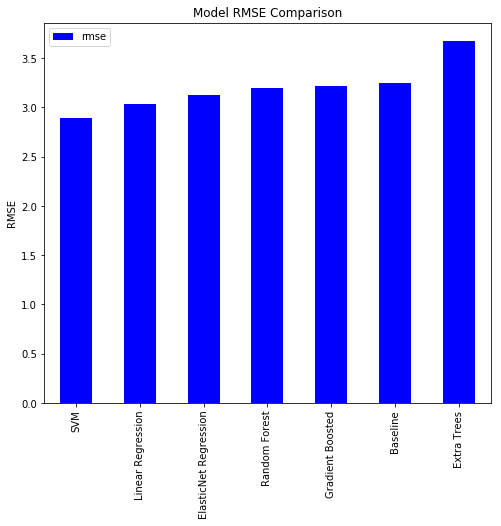

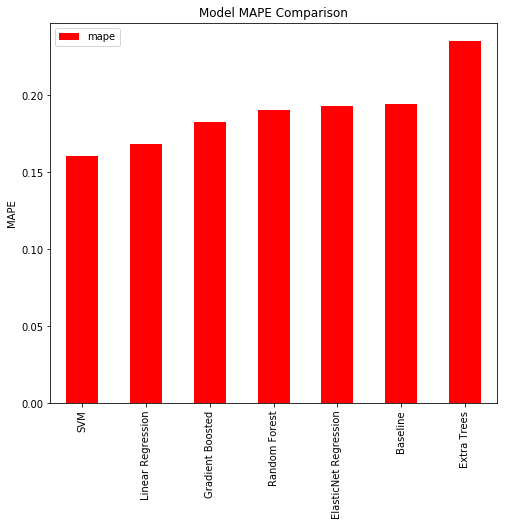

In [52]:
figsize(8, 7)
# Root mean squared error
ax = math_results.sort_values('rmse', ascending = True).plot.bar(y = 'rmse', color = 'b')
plt.title('Model RMSE Comparison'); plt.ylabel('RMSE');

# Median absolute percentage error
math_results.sort_values('mape', ascending = True).plot.bar(y = 'mape', color = 'r')
plt.title('Model MAPE Comparison'); plt.ylabel('MAPE');

From the metrics, we can see that the Support Vector Machine Regression performs the best followed by the ordinary linear regression. I did not do any hyperparameter tuning with these models, and we are only using them as a baseline for comparison. 

# First Attempt at Bayesian Linear Regression

We will be using the `GLM.from_formula` function in PyMC3 which means we need to create a formula relating the explanatory variables (the features) to the response (the final grade). The `GLM.from_formula` function call uses the R formula syntax which is shown below. When the model performs inference, it will draw samples from the posterior for each of the variables in the formula, along with an intercept and a variance. 

In [56]:
X_train_math['y'] = list(y_train_math)
formula = 'y ~ ' + ' + '.join(['%s' % variable for variable in X_train_math.columns[:-1]])

### Formula for Linear Regression

In [57]:
formula

'y ~ failures + schoolsup_no + schoolsup_yes + Fjob_teacher + absences + Walc + Fedu + Medu'

Now, we can create the model using PyMC3 and perform Markov Chain Monte Carlo to sample from the posterior. The function `GLM.from_formula` parses the formula string, adds a random variable for each regressor, a likelihood for each random variable (by default a normal distribution. The function then initializes the parameters (weights, $\beta$) to sensible starting point using a frequentists estimate using statsmodels. 

After we perform the sampling, we can examine the varibles from the trace to make predictions and examine the weights of different variables. 

In [58]:
with pm.Model() as lin_model:
    # Error term
    pm.GLM.from_formula(formula, X_train_math)
    
    # Perform Markov Chain Monte Carlo sampling
    lin_trace = pm.sample(draws=1000, njobs=-1)

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '13508' (I am process '13660')
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_log__, Medu, Fedu, Walc, absences, Fjob_teacher, schoolsup_yes, schoolsup_no, failures, Intercept]
100%|██████████| 1500/1500 [11:01<00:00,  2.27it/s]
There were 222 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.37967568025292464, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 222 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6691740116150431, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree

This model uses the auto-assignment in PyMC3 for sampling. In this case, the model uses the [No-UTurn Sampling method (NUTS)](http://jmlr.org/papers/volume15/hoffman14a/hoffman14a.pdf) which is a special case of [Hamiltonian Monte Carlo (HMC))](https://arxiv.org/abs/1701.02434) sampling. Hamiltonian Monte Carlo methods avoid the common random walk behavior of Markov Chain Monte Carlo algorithms by taking steps informed by the first-order gradient. NUTS automatically stops when it begins to double back and retrace steps (No-UTurn) and is generally more efficient than Hamiltonian Monte Carlo which is in turn more efficient than Markov Chain Monte Carlo. HMC converges more quickly than standard MCMC because it avoids the random walk behavior and is an informed sampling method.

# Examine Results

Rather than provide us with a single estimate for each of the weights, Markov Chain Monte Carlo sampling gives us a distribution of samples for every model parameter. We can use `pm.traceplot` to examine the distribution of every variable sampled by the model. 

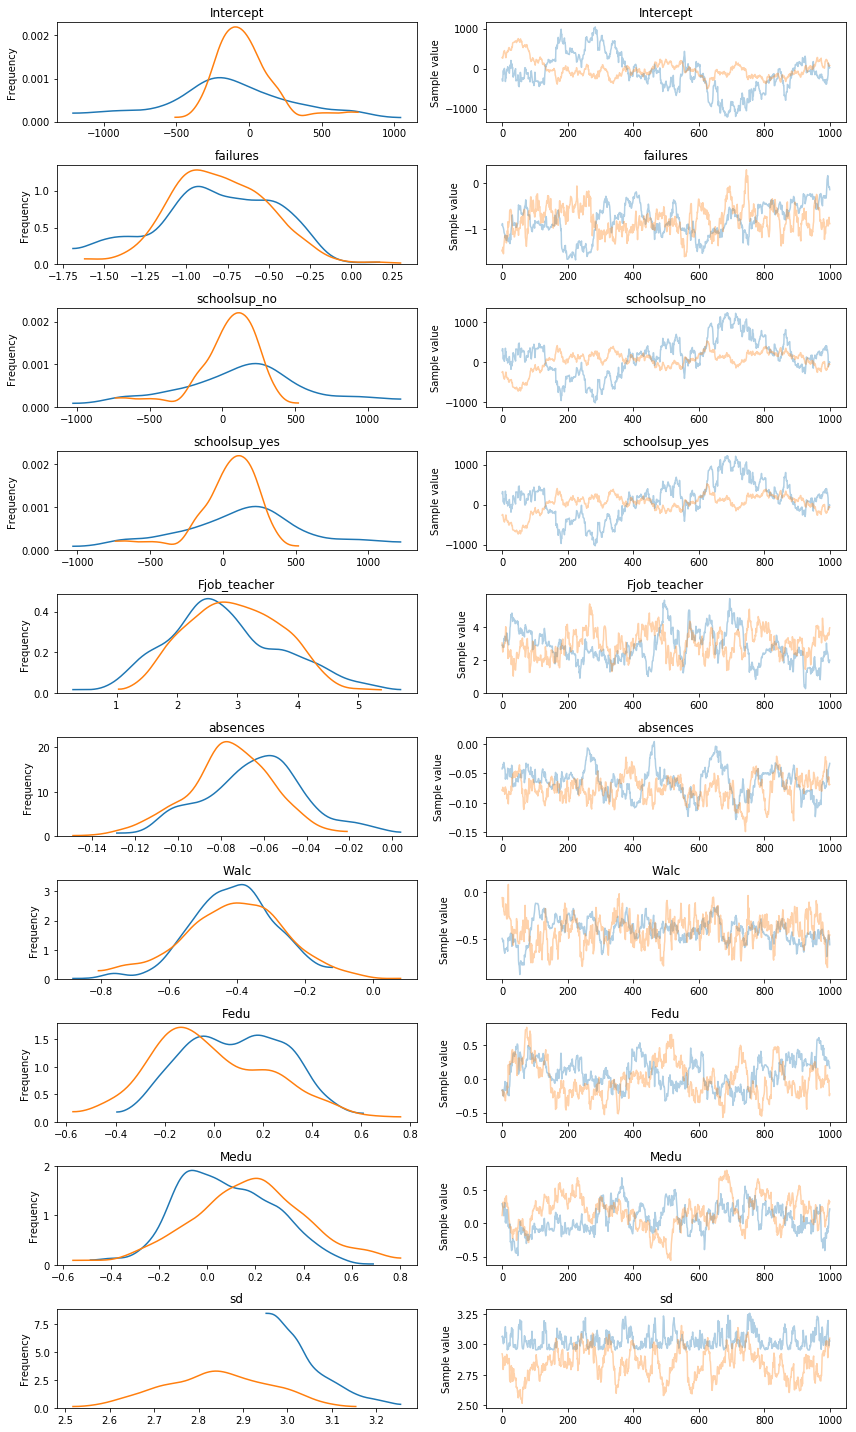

In [59]:
pm.traceplot(lin_trace);

The left side of the traceplot is the marginal posterior: the values for the variable are on the x-axis with the probability for the variable (as determined by sampling) on the y-axis. The different colored lines indicate that we performed two chains of Markov Chain Monte Carlo. From the left side we can see that there is a range of values for each weight. The right side shows the different sample values drawn as the sampling process runs. 

Another method built into PyMC3 for examinig trace results is the forestplot which shows the distribution of each sampled parameter. This allows us to see the uncertainty in each sample. The forestplot is easily constructed from the trace using `pm.forestplot`.

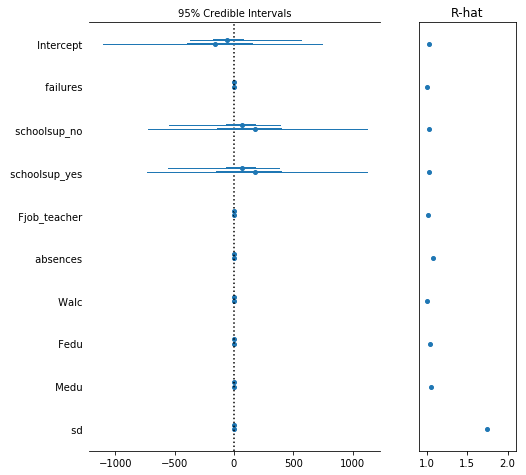

In [60]:
pm.forestplot(lin_trace);

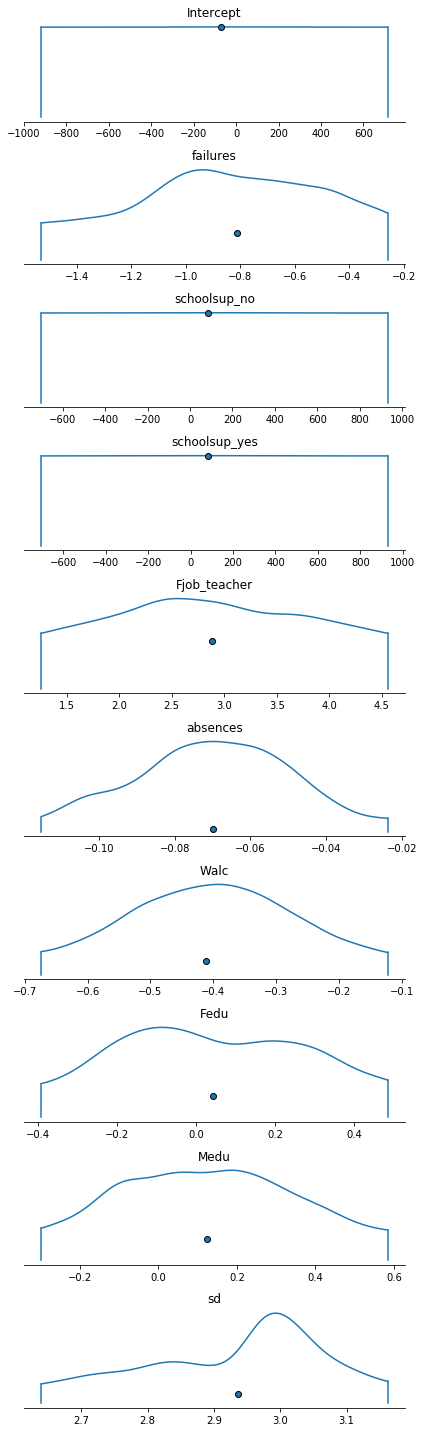

In [63]:
pm.densityplot(lin_trace);

## Make Predictions Using Most Likely Values

Now, we can make predictions for students outcomes using the trace samples. To come up with a single estimate, we take the mean of all the parameter samples. 

In [148]:
def evaluate_trace(trace, X_train, X_test, y_train, y_test, model_results):
    
    # Dictionary of all sampled values for each parameter
    var_dict = {}
    for variable in trace.varnames:
        var_dict[variable] = trace[variable]
        
    # Results into a dataframe
    var_weights = pd.DataFrame(var_dict)
    
    var_means = var_weights.mean(axis=0)
    var_std = var_weights.std(axis=0)
    
    X_train['Intercept'] = 1
    X_test['Intercept'] = 1
    
    names = X_train.columns
    X_test = X_test.ix[:, names]

    var_means = var_means[names]
    
    results = pd.DataFrame(index = X_test.index, columns = ['estimate'])
    
    for row in X_test.iterrows():
        results.ix[row[0], 'estimate'] = np.dot(np.array(var_means), np.array(row[1]))
        
    actual = np.array(y_test)
    errors = results['estimate'] - actual
    
    
    rmse = np.sqrt(mean_squared_error(results['estimate'], actual))
    mape = np.median(abs(errors) / actual)
    
    print('Model RMSE: {:.4f}\nModel MAPE: {:.4f}'.format(rmse, mape))

    figsize(10, 10)
    plt.scatter(results.index, actual, label = 'Observed', color = 'blue')
    plt.scatter(results.index, results['estimate'], label = 'Estimate', color = 'red')
    plt.legend(prop={'size': 14}); plt.xlabel('Index'); plt.ylabel('Grade');
    plt.title('Observed and Estimated Values')
    plt.show()
    
    
    model_results.ix['Bayesian GLM', :] = [rmse, mape]
    
    
    # Root mean squared error
    plt.figure(figsize=(12, 6))
    ax = plt.subplot(1, 2, 1)
    model_results.sort_values('rmse', ascending = True).plot.bar(y = 'rmse', color = 'b', ax = ax)
    plt.title('Model RMSE Comparison'); plt.ylabel('RMSE')

    # Median absolute percentage error
    ax = plt.subplot(1, 2, 2)
    model_results.sort_values('mape', ascending = True).plot.bar(y = 'mape', color = 'r', ax = ax)
    plt.title('Model MAPE Comparison'); plt.ylabel('MAPE'); 
    plt.show();
    
    return results

Model RMSE: 2.7797
Model MAPE: 0.1683


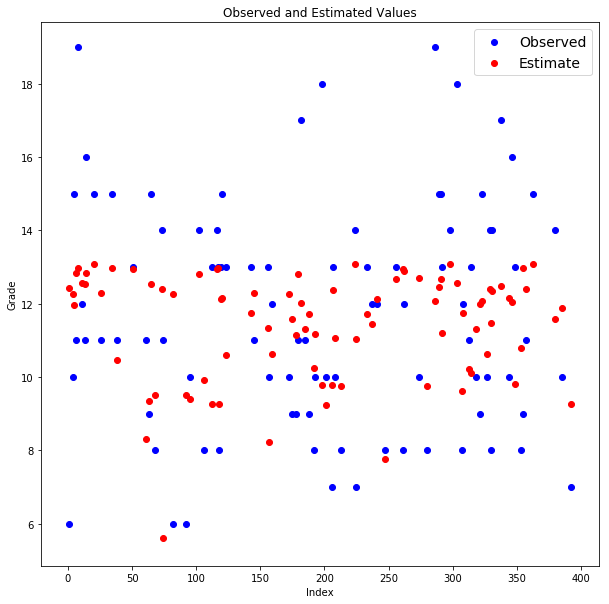

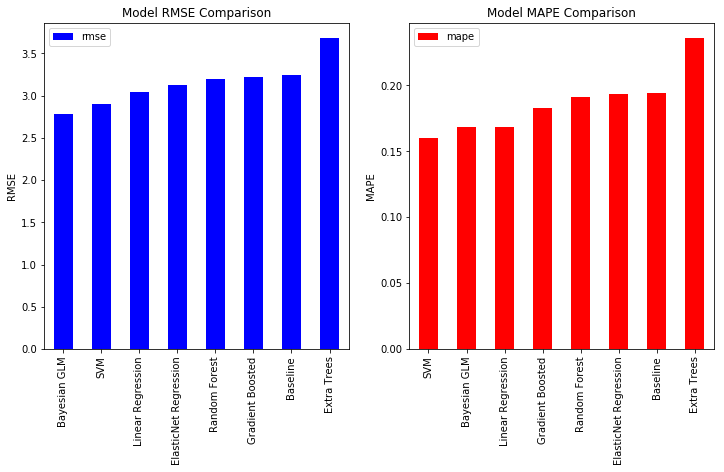

In [150]:
results = evaluate_trace(lin_trace, X_train_math, X_test_math, y_train_math, y_test_math, math_results)

Our first attempt at creating a Bayesian Generalized Linear Model performs better than all the other models in terms of Root-Mean Squared Error! It is right behind the support vector machine for Median Absolute Percentage Error. Now, we can query the model, putting in any combination of variables we want and receive a prediction based on the model weights.

In [151]:
def query_model(trace, new_observation):
     # Dictionary of all sampled values for each parameter
    var_dict = {}
    for variable in trace.varnames:
        var_dict[variable] = trace[variable]
        
    # Results into a dataframe
    var_weights = pd.DataFrame(var_dict)

['Intercept',
 'failures',
 'schoolsup_no',
 'schoolsup_yes',
 'Fjob_teacher',
 'absences',
 'Walc',
 'Fedu',
 'Medu',
 'sd_log__',
 'sd']

In [155]:
 # Dictionary of all sampled values for each parameter
var_dict = {}
for variable in lin_trace.varnames:
    var_dict[variable] = lin_trace[variable]

# Results into a dataframe
var_weights = pd.DataFrame(var_dict)

In [156]:
var_weights.head()

,Fedu,Fjob_teacher,Intercept,Medu,Walc,absences,failures,schoolsup_no,schoolsup_yes,sd,sd_log__
0,-0.170563,2.896888,-263.865602,0.297245,-0.496097,-0.042507,-0.921621,277.065750,274.609842,3.061844,1.119017
1,-0.180722,2.883487,-312.453269,0.273945,-0.508643,-0.040113,-0.885877,326.089560,323.541989,3.066753,1.120619
2,-0.161137,2.880900,-313.446222,0.249537,-0.515826,-0.041603,-0.950127,326.794742,324.328584,3.048210,1.114555
3,-0.246830,2.769360,-93.463095,0.247366,-0.533694,-0.034919,-0.962881,107.126536,104.626805,3.024051,1.106597
4,-0.258665,2.754995,-45.537708,0.202015,-0.515861,-0.035703,-0.987996,59.038164,57.021495,3.004393,1.100076
